In [24]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

##plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

## Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [25]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [26]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [27]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [28]:
df_ibis = pd.read_csv('../../../data/processed/cleaned_ibis-sg-bencoolen.csv')
df_boss = pd.read_csv('../../../data/processed/cleaned_hotel-boss.csv')
df_g = pd.read_csv('../../../data/processed/cleaned_hotel-G.csv')
df_village = pd.read_csv('../../../data/processed/cleaned_village-hotel-albert-court-by-far-east-hospitality.csv')
df_holiday = pd.read_csv('../../../data/processed/cleaned_holiday-inn-express-clarke-quay.csv')


df_combi = pd.concat([df_ibis, df_boss, df_g, df_village, df_holiday])

In [29]:
##filter for year >= 2015
df_filtered = df_combi[df_combi['date'] >= '2015-01-01']

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.extend(['ibis', 'boss', 'village', 'ibis_bencoolen', 'bencoolen', 'albert', 'far_east', 'east_hospitality',
           'clarke', 'quay', 'express', 'clarke_quay', 'albert_court', 'court', 'clark', 'inn', 'marina'])

stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Stem Review

In [30]:
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_stopwords)
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['stem_tokens'] = df_filtered['stem_review'].apply(preprocess)

In [31]:
df_filtered

,travel_type,rating,label,combined_review,date,covid,is_local,stem_review,lem_review,cleaned_review,stem_tokens
0,couple,4.0,Positive,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,0,clean comfort hotel room find decent hotel tra...,clean comfortable hotel room singapore expensi...,clean comfortable hotel rooms singapore expens...,"[clean, comfort, hotel, room, find, decent, ho..."
1,family,5.0,Positive,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,0,good hotel great great place great room small ...,good hotel great location great place location...,good hotel great location great place location...,"[good, hotel, great, great, place, great, room..."
2,friends,5.0,Positive,Good place for a decent price. Good place good...,2022-10-01,PostCovid,0,good place decent price good place good price ...,good place decent price good place good price ...,good place decent price good place good price ...,"[good, place, decent, price, good, place, good..."
3,solo,5.0,Positive,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,0,great great staff neat hotel line star rate st...,great location great staff ibis neat tidy hote...,great location great staff ibis neat tidy hote...,"[great, great, staff, neat, hotel, line, star,..."
4,business,4.0,Positive,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,0,good budget stay stay day nice seven eleven ne...,good budget stay stay day nice location seven ...,good budget stay stayed days nice location sev...,"[good, budget, stay, stay, day, nice, seven, e..."
...,...,...,...,...,...,...,...,...,...,...,...
2199,NaN,4.0,Positive,small but enough i stay from 1/6 to 1/9\r\nthe...,2015-01-01,PreCovid,0,small enough stay close station swim pool smal...,small enough stay location excellet close mrt ...,small enough stay location excellet close mrt ...,"[small, enough, stay, close, station, swim, po..."
2201,NaN,5.0,Positive,Great Experience I visited Singapore recently ...,2015-01-01,PreCovid,0,great visit recent short day night must say ho...,great experience visit singapore recently fami...,great experience visited singapore recently fa...,"[great, visit, recent, short, day, night, must..."
2202,NaN,4.0,Positive,"Good hotel, great location.. My husband and I ...",2015-01-01,PreCovid,0,good hotel great husband stay night halfway st...,good hotel great location husband stay night s...,good hotel great location husband stayed night...,"[good, hotel, great, husband, stay, night, hal..."
2206,NaN,3.0,Neutral,My stay at this hotel The staff were all frien...,2015-01-01,PreCovid,0,stay hotel staff room passageway room b room l...,stay hotel staff friendly efficient room adequ...,stay hotel staff friendly efficient rooms adeq...,"[stay, hotel, staff, room, passageway, room, b..."


In [32]:
##Generate LDA dictionary and corpus
#stem_dict = corpora.Dictionary(df_filtered['stem_tokens']) #used if we want to refresh it
#stem_dict.save('3star_stem')
stem_dict = corpora.Dictionary.load('3star_stem')
stem_corpus = [stem_dict.doc2bow(text) for text in df_filtered['stem_tokens']]

In [ ]:
## find best_coherence (Don't run, takes too long to run):
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    stem_ldamodel = lda(stem_corpus, num_topics=i, id2word=stem_dict, passes=15, random_state=0)
    
    stemming_coherence = CoherenceModel(model=stem_ldamodel, texts=df_filtered['stem_tokens'], 
                                        dictionary=stem_dict, coherence='c_v')
    lda_coherence = stemming_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

In [33]:
## Use 5 topics as indicated by coherence
lda = gensim.models.ldamodel.LdaModel
stem_ldamodel = lda(stem_corpus, num_topics=5, id2word=stem_dict, passes=15, random_state=0)

In [34]:
# For stemming
topics_stem = stem_ldamodel.show_topics(formatted=False, num_words=20)
data_flat_stem = [word for word_list in df_filtered['stem_tokens'] for word in word_list]

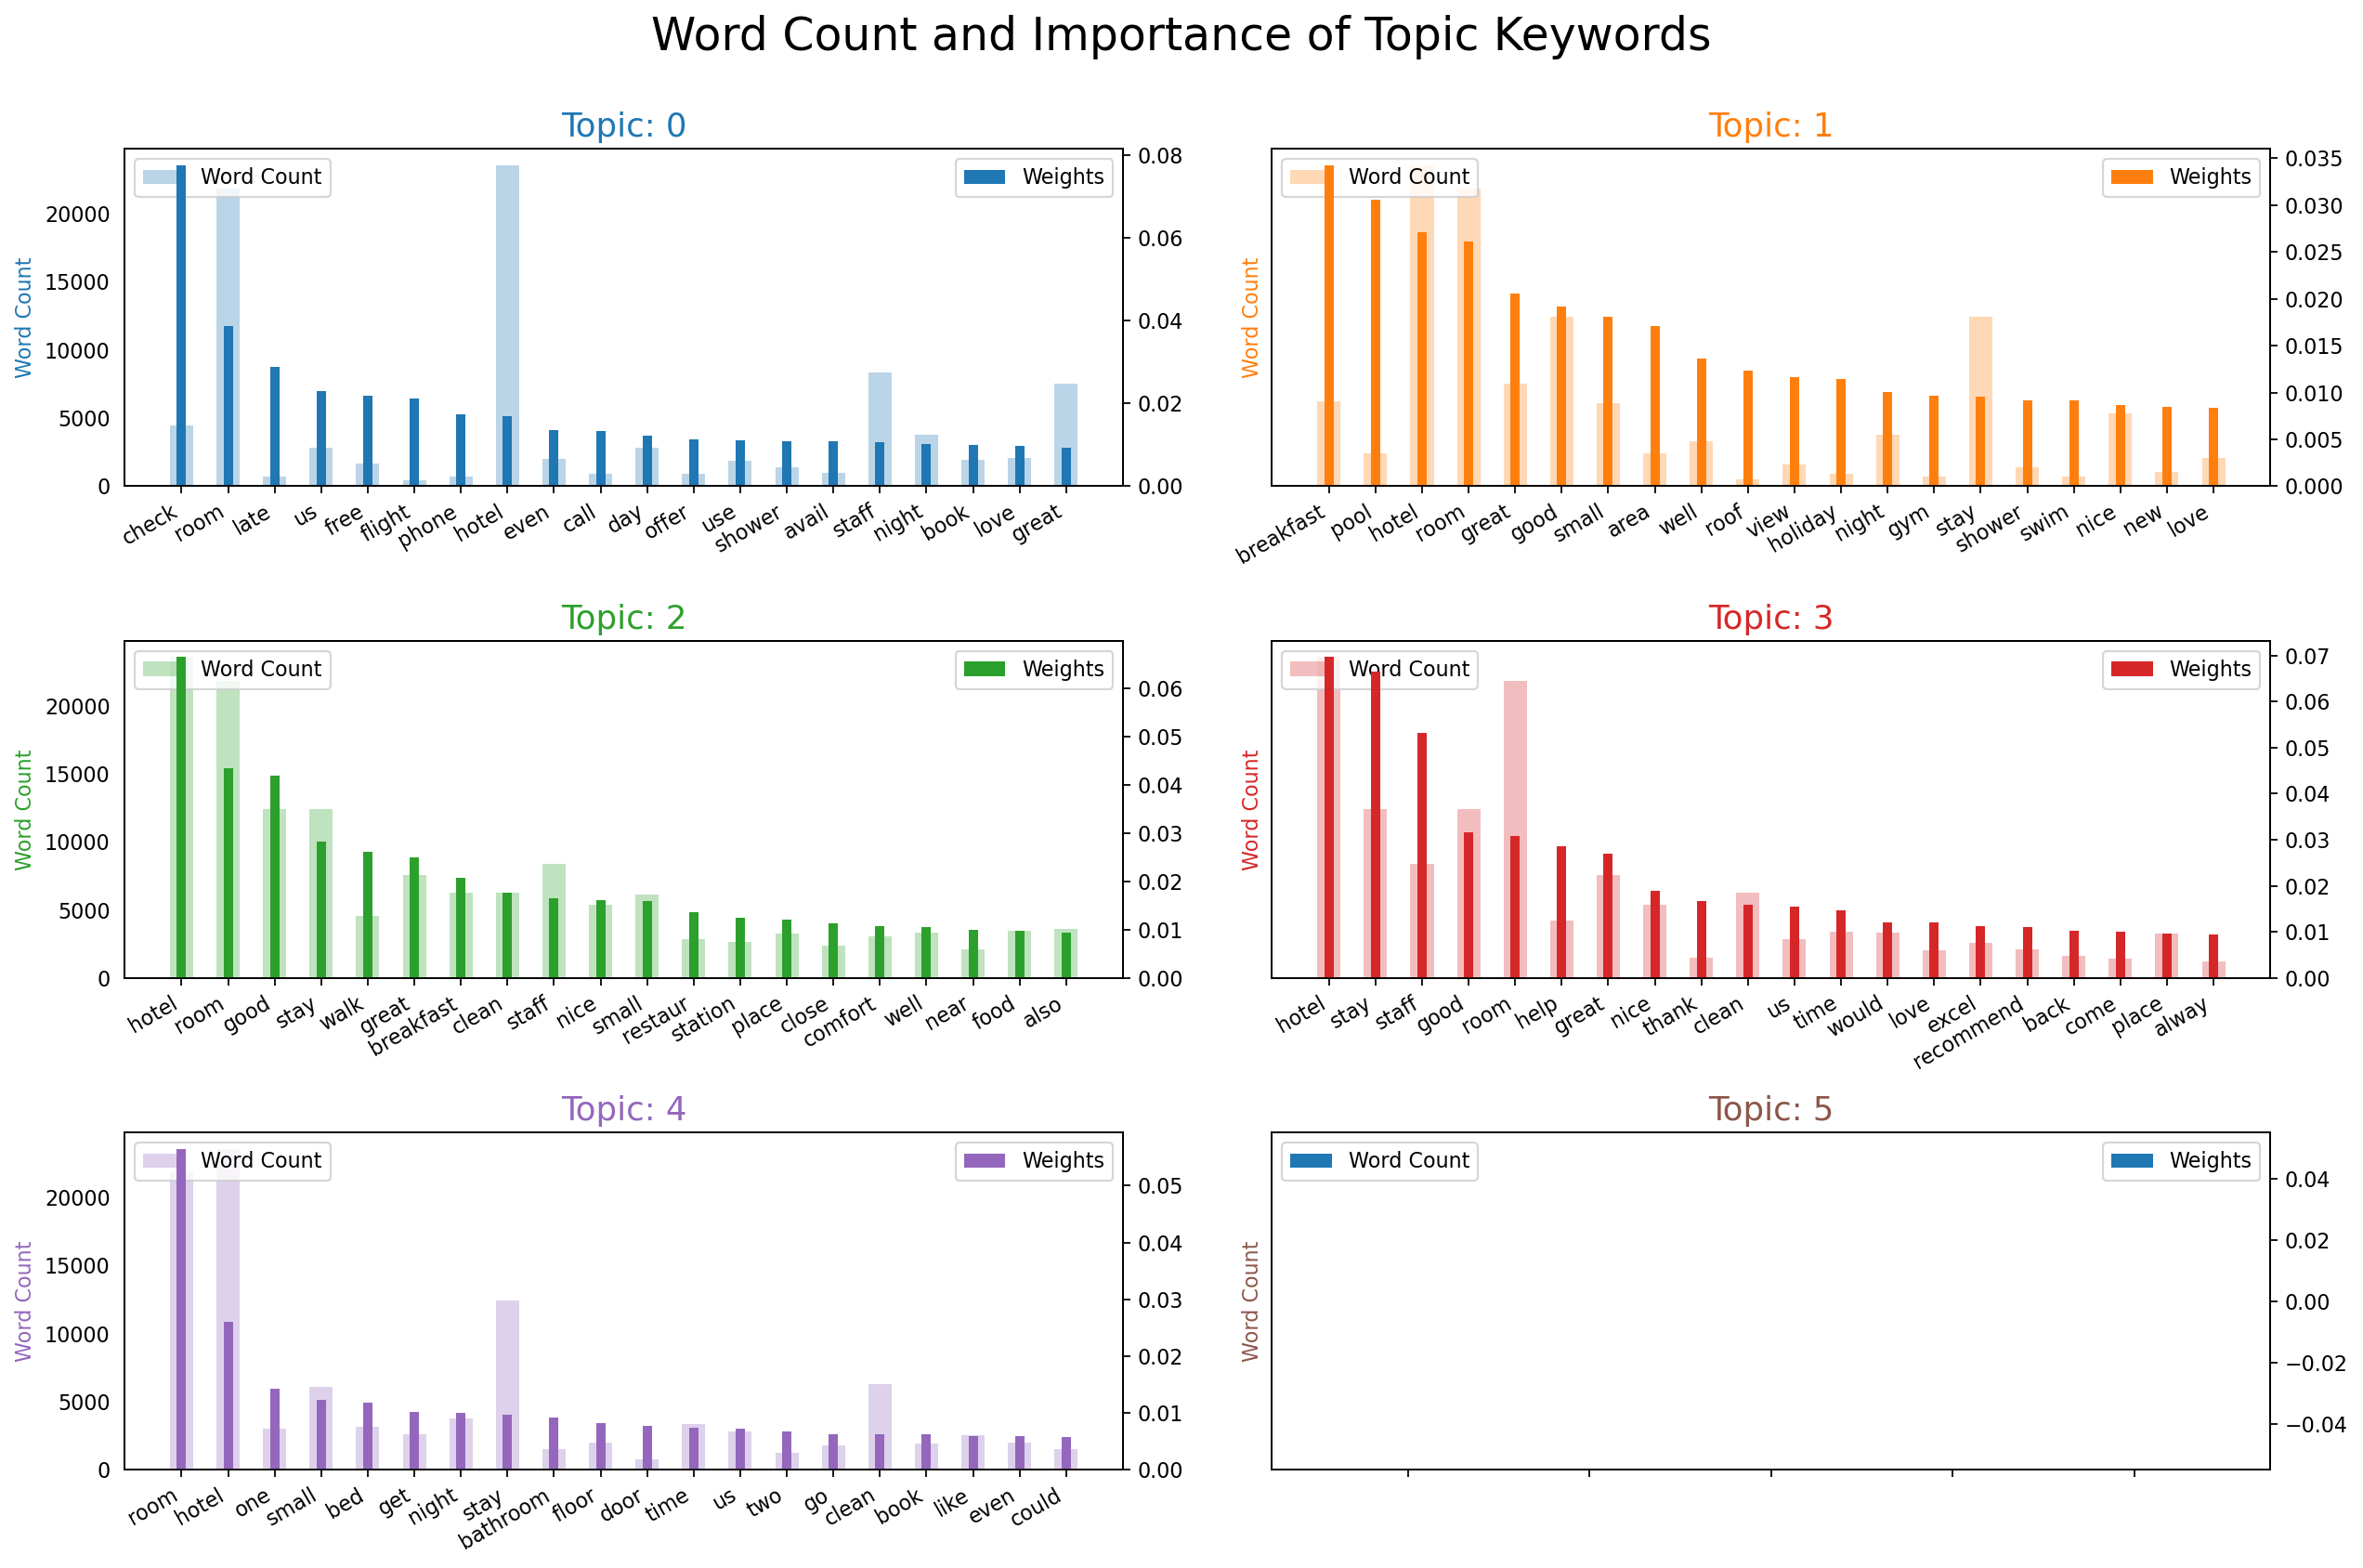

In [35]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For all topics
plot_word_count_importance(topics_stem, data_flat_stem, 'Word Count and Importance of Topic Keywords')

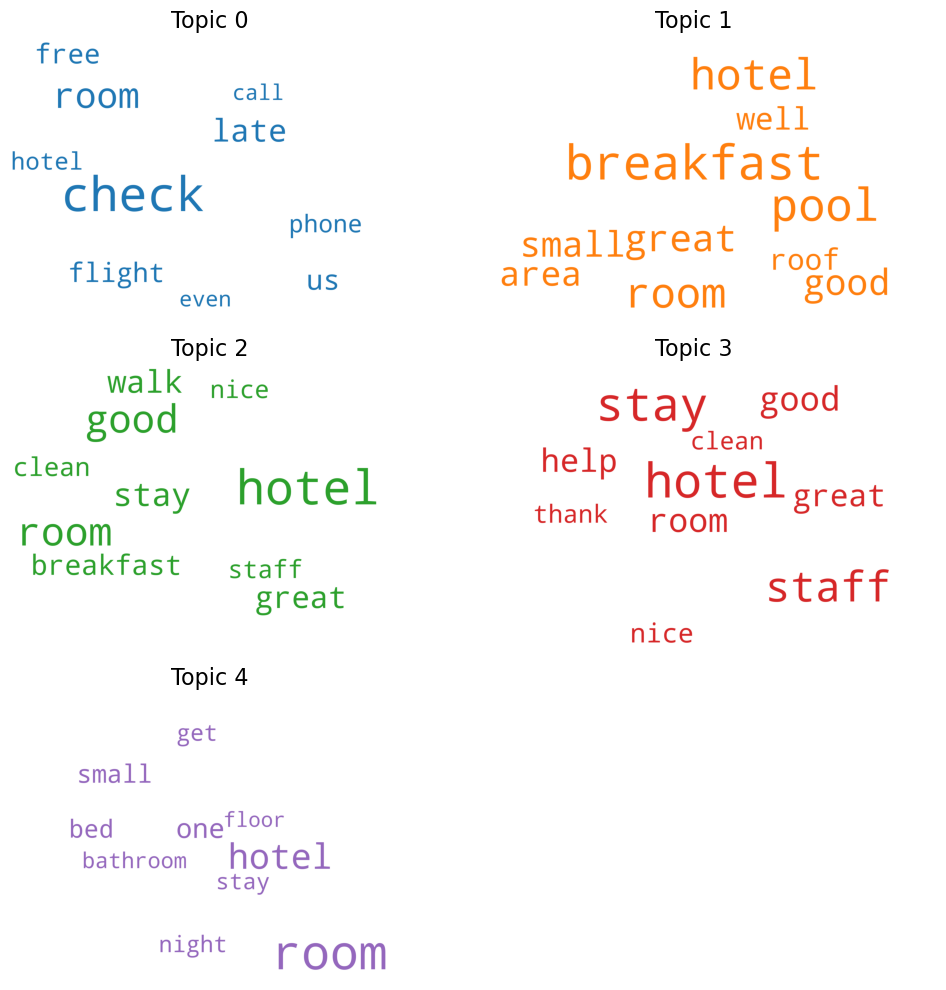

In [36]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(stem_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for all topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [37]:
vis = pyLDAvis.gensim.prepare(topic_model=stem_ldamodel, corpus=stem_corpus, dictionary=stem_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Lemmatized

In [38]:
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_stopwords)
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['lem_tokens'] = df_filtered['lem_review'].apply(preprocess)

In [39]:
##Generate LDA dictionary and corpus
#lem_dict = corpora.Dictionary(df_filtered['lem_tokens']) #used if you want to refresh dict
#lem_dict.save('3star_lem')
lem_dict = corpora.Dictionary.load('3star_lem')
lem_corpus = [lem_dict.doc2bow(text) for text in df_filtered['lem_tokens']]

In [ ]:
## find best_coherence (Don't run, takes too long to run):
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    lem_ldamodel = lda(lem_corpus, num_topics=i, id2word=lem_dict, passes=15, random_state=0)
    
    lem_coherence = CoherenceModel(model=lem_ldamodel, texts=df_filtered['lem_tokens'], dictionary=lem_dict, coherence='c_v')
    lda_coherence = lem_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

In [40]:
## Use 3 topics as determined by coherence
lda = gensim.models.ldamodel.LdaModel
lem_ldamodel = lda(lem_corpus, num_topics=3, id2word=lem_dict, passes=15, random_state=0)

In [41]:
# For All
topics_lem = lem_ldamodel.show_topics(formatted=False)
data_flat_lem = [word for word_list in df_filtered['lem_tokens'] for word in word_list]

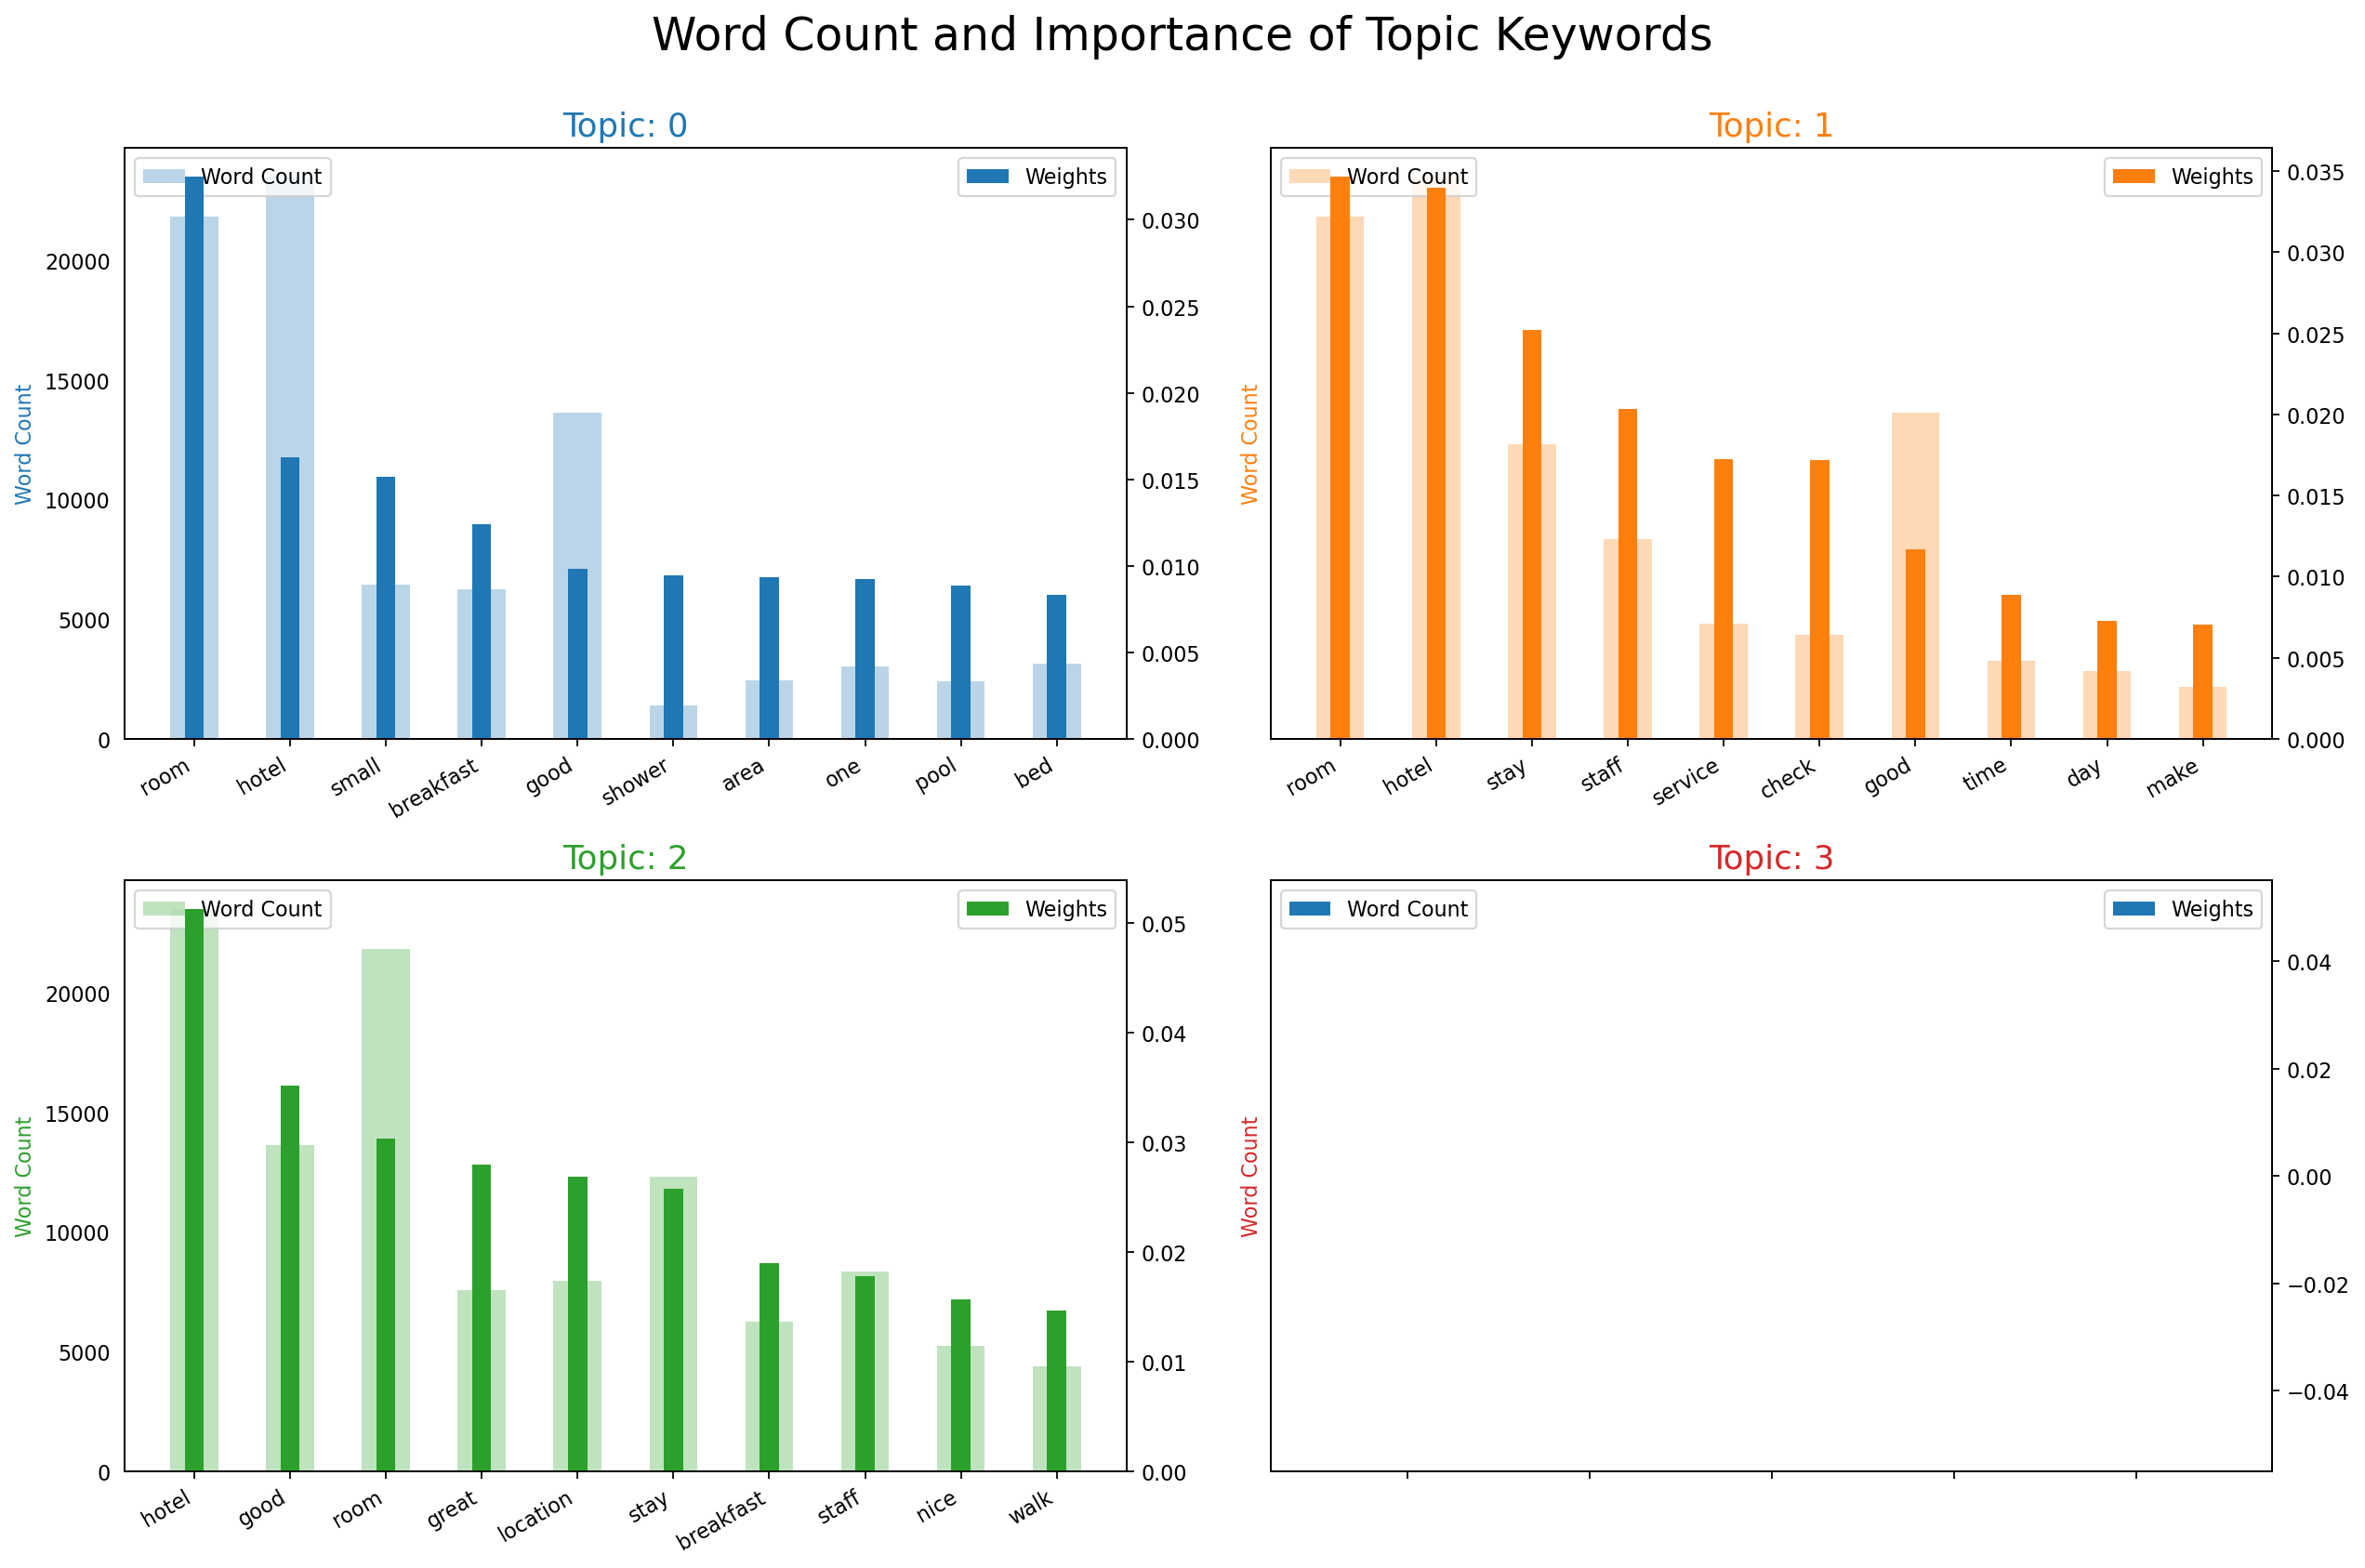

In [42]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# Plotting all topics
plot_word_count_importance(topics_lem, data_flat_lem, 'Word Count and Importance of Topic Keywords')

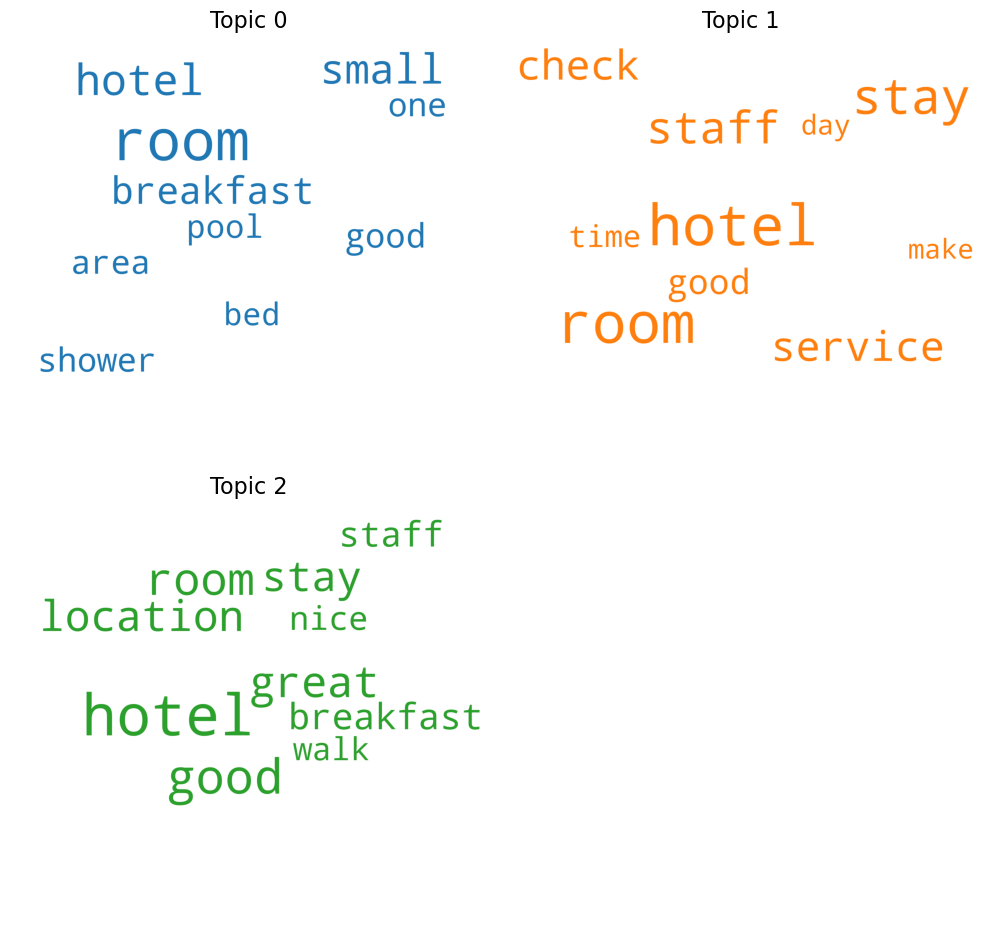

In [43]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the dataset
clouds_pre = []

for i in range(3):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(lem_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for all topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [44]:
vis = pyLDAvis.gensim.prepare(topic_model=lem_ldamodel, corpus=lem_corpus, dictionary=lem_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Topic Extraction

In [45]:
topics_stem

[(0,
  [('check', 0.07754221),
   ('room', 0.038632233),
   ('late', 0.0287011),
   ('us', 0.02297527),
   ('free', 0.021750309),
   ('flight', 0.021106116),
   ('phone', 0.01733447),
   ('hotel', 0.016891772),
   ('even', 0.0135511635),
   ('call', 0.013317952),
   ('day', 0.012166229),
   ('offer', 0.011367533),
   ('use', 0.011115009),
   ('shower', 0.010950918),
   ('avail', 0.010851161),
   ('staff', 0.010670348),
   ('night', 0.010132152),
   ('book', 0.009971127),
   ('love', 0.009783751),
   ('great', 0.009183307)]),
 (1,
  [('breakfast', 0.034278683),
   ('pool', 0.030564915),
   ('hotel', 0.027128836),
   ('room', 0.026081096),
   ('great', 0.02059655),
   ('good', 0.019135173),
   ('small', 0.018040646),
   ('area', 0.017044589),
   ('well', 0.013666795),
   ('roof', 0.012311558),
   ('view', 0.011596671),
   ('holiday', 0.011423616),
   ('night', 0.010018452),
   ('gym', 0.009669362),
   ('stay', 0.009555898),
   ('shower', 0.009173747),
   ('swim', 0.009164433),
   ('nice'

In [46]:
top_dict = {}
for i in topics_stem:
    top_dict[i[0]] = []
    for j in i[1]:
        top_dict[i[0]].append(j[0])

In [47]:
top_dict

{0: ['check',
  'room',
  'late',
  'us',
  'free',
  'flight',
  'phone',
  'hotel',
  'even',
  'call',
  'day',
  'offer',
  'use',
  'shower',
  'avail',
  'staff',
  'night',
  'book',
  'love',
  'great'],
 1: ['breakfast',
  'pool',
  'hotel',
  'room',
  'great',
  'good',
  'small',
  'area',
  'well',
  'roof',
  'view',
  'holiday',
  'night',
  'gym',
  'stay',
  'shower',
  'swim',
  'nice',
  'new',
  'love'],
 2: ['hotel',
  'room',
  'good',
  'stay',
  'walk',
  'great',
  'breakfast',
  'clean',
  'staff',
  'nice',
  'small',
  'restaur',
  'station',
  'place',
  'close',
  'comfort',
  'well',
  'near',
  'food',
  'also'],
 3: ['hotel',
  'stay',
  'staff',
  'good',
  'room',
  'help',
  'great',
  'nice',
  'thank',
  'clean',
  'us',
  'time',
  'would',
  'love',
  'excel',
  'recommend',
  'back',
  'come',
  'place',
  'alway'],
 4: ['room',
  'hotel',
  'one',
  'small',
  'bed',
  'get',
  'night',
  'stay',
  'bathroom',
  'floor',
  'door',
  'time',
  '

In [48]:
df_res = pd.DataFrame(top_dict)
df_res

,0,1,2,3,4
0,check,breakfast,hotel,hotel,room
1,room,pool,room,stay,hotel
2,late,hotel,good,staff,one
3,us,room,stay,good,small
4,free,great,walk,room,bed
5,flight,good,great,help,get
6,phone,small,breakfast,great,night
7,hotel,area,clean,nice,stay
8,even,well,staff,thank,bathroom
9,call,roof,nice,clean,floor


In [49]:
df_res.to_csv('3-star LDA.csv')

## DP

In [50]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [51]:
# Pass in LDA topics output to remove overlap words by choosing highest prob
def restruct_topics(topics): 
    word_prob_dict = {}
    for i in range(len(topics)):
        topic_num = topics[i][0]
        for word, prob in topics[i][1]:
            if word in word_prob_dict:
                word_prob_dict[word].append((topic_num, prob))
            else:
                ls = [(topic_num, prob)]
                word_prob_dict[word] = ls
    new_dict = {}
    for word in word_prob_dict:
        topic, highest_prob = max(word_prob_dict[word], key = lambda x: x[1])
        if topic in new_dict:
            new_dict[topic].append(word)
        else:
            ls = [word]
            new_dict[topic] = ls
    return new_dict

In [52]:
new_dict = restruct_topics(topics_stem)

In [53]:
new_dict = restruct_topics(topics_stem)
for x in new_dict:
    print(f'length topic {x}: {len(new_dict[x])}')

length topic 0: 15
length topic 4: 11
length topic 3: 15
length topic 1: 11
length topic 2: 11


In [54]:
#takes in the dataframe and appends to each row (aspect, review) pair(s)
def dep_parse(data, new_dict):
    data['aspect_sentiment'] = np.empty((len(data), 0)).tolist()
    for i in range(len(data)):
        sentence = data['combined_review'][i]
        doc = nlp(sentence)
        aspect_sentiment = []
        for word in doc:
            cond = False
            for x in new_dict.values():
                if word.text in x:
                    cond = True
                    break
            if not cond:
                continue
            if word.pos_ == 'NOUN': 
                for j in word.lefts:
                    #print(j, word, j.dep_, j.pos_)
                    if j.dep_ == 'amod' and j.pos_ == 'ADJ':
                        tup = [word, j, list(new_dict.values()).index(x)]
                        #print(tup)
                        aspect_sentiment.append(tup)
                    for k in j.lefts:
                        if k.dep_ == 'advmod':
                            #print(word, j ,k)
                            tup = (word, k.text + ' ' + j.text)
                            aspect_sentiment.append(tup)
                            if (word, j) in aspect_sentiment:
                                aspect_sentiment.remove([word, j, list(new_dict.values()).index(x)])
        data['aspect_sentiment'][i] = aspect_sentiment

In [55]:
df_filtered = df_filtered.reset_index()

In [72]:
dep_parse(df_filtered, new_dict)

In [73]:
df_filtered['aspect_sentiment']

0        [[hotel, decent, 2], [room, compact, 1], [bath...
1        [[hotel, Good, 2], [place, great, 4], [hotel, ...
2                     [[place, Good, 4], [place, Good, 4]]
3        [[staff, great, 2], [hotel, neat, 2], [door, n...
4                       [[door, next, 1], [time, long, 2]]
                               ...                        
14065                                                   []
14066                                                   []
14067                [[hotel, Good, 2], [room, actual, 1]]
14068                                [[room, adjacent, 1]]
14069                                    [[time, next, 2]]
Name: aspect_sentiment, Length: 14070, dtype: object

In [76]:
df_filtered.head()

,index,travel_type,rating,label,combined_review,date,covid,is_local,stem_review,lem_review,cleaned_review,stem_tokens,lem_tokens,vec_tokens,aspect_sentiment
0,0,couple,4.0,Positive,Clean and comfortable Hotel rooms in Singapore...,2023-08-01,PostCovid,0,clean comfort hotel room find decent hotel tra...,clean comfortable hotel room expensive find de...,clean comfortable hotel rooms singapore expens...,"[clean, comfort, hotel, room, find, decent, ho...","[clean, comfortable, hotel, room, expensive, f...",clean comfort hotel room find decent hotel tra...,"[[hotel, decent, 2], [room, compact, 1], [bath..."
1,1,family,5.0,Positive,"Good hotel, great location This is a great pl...",2023-08-01,PostCovid,0,good hotel great great place great room small ...,good hotel great location great place location...,good hotel great location great place location...,"[good, hotel, great, great, place, great, room...","[good, hotel, great, location, great, place, l...",good hotel great great place great room small ...,"[[hotel, Good, 2], [place, great, 4], [hotel, ..."
2,2,friends,5.0,Positive,Good place for a decent price. Good place good...,2022-10-01,PostCovid,0,good place decent price good place good price ...,good place decent price good place good price ...,good place decent price good place good price ...,"[good, place, decent, price, good, place, good...","[good, place, decent, price, good, place, good...",good place decent price good place good price ...,"[[place, Good, 4], [place, Good, 4]]"
3,3,solo,5.0,Positive,Great Location and great staff. The IBIS was a...,2023-08-01,PostCovid,0,great great staff neat hotel line star rate st...,great location great staff neat tidy hotel lin...,great location great staff ibis neat tidy hote...,"[great, great, staff, neat, hotel, line, star,...","[great, location, great, staff, neat, tidy, ho...",great great staff neat hotel line star rate st...,"[[staff, great, 2], [hotel, neat, 2], [door, n..."
4,4,business,4.0,Positive,Good for budget stay. I stayed there for 7 day...,2022-08-01,PostCovid,0,good budget stay stay day nice seven eleven ne...,good budget stay stay day nice location seven ...,good budget stay stayed days nice location sev...,"[good, budget, stay, stay, day, nice, seven, e...","[good, budget, stay, stay, day, nice, location...",good budget stay stay day nice seven eleven ne...,"[[door, next, 1], [time, long, 2]]"


In [74]:
df_filtered.to_csv('3star-DP.csv')

## Import PyABSA

In [56]:
df_test = pd.read_json('../pyABSA_outputs/Aspect_Term_Extraction_and_Polarity_Classification_FAST_LCF_ATEPC.json')

In [57]:
df_test

,sentence,IOB,tokens,aspect,position,sentiment,probs,confidence
0,clean comfort hotel room find decent hotel tra...,"[O, B-ASP, O, O, O, O, O, O, O, B-ASP, O, O, O...","[clean, comfort, hotel, room, find, decent, ho...","[comfort, food, glass, closet space, port]","[[1], [9], [30], [37, 38], [47]]","[Positive, Negative, Negative, Negative, Negat...","[[0.022732432931661002, 0.002103362465277, 0.9...","[0.9752000000000001, 0.922, 0.8991, 0.86620000..."
1,good hotel great great place great room small ...,"[O, O, O, O, B-ASP, O, O, O, O, O, O, O, O, O,...","[good, hotel, great, great, place, great, room...",[place],[[4]],[Positive],"[[0.0005702517228200001, 0.0003066391509490000...",[0.9991000000000001]
2,good place decent price good place good price ...,"[O, O, O, B-ASP, O, O, O, O, O, O, O, O, B-ASP...","[good, place, decent, price, good, place, good...","[price, food]","[[3], [12]]","[Positive, Negative]","[[0.005487654823809001, 0.013030127622187, 0.9...","[0.9815, 0.912]"
3,great great staff neat hotel line star rate st...,"[O, O, B-ASP, O, O, O, O, O, O, B-ASP, I-ASP, ...","[great, great, staff, neat, hotel, line, star,...","[staff, front desk]","[[2], [9, 10]]","[Positive, Positive]","[[0.032106801867485005, 0.00041079759830600003...","[0.9675, 0.9994000000000001]"
4,good budget stay stay day nice seven eleven ne...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[good, budget, stay, stay, day, nice, seven, e...",[wait],[[18]],[Positive],"[[0.408927053213119, 0.019343916326761003, 0.5...",[0.5717]
...,...,...,...,...,...,...,...,...
68287,swiss hotel swiss stay hotel mani time recent ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[swiss, hotel, swiss, stay, hotel, mani, time,...","[size, staff, porter, crew]","[[15], [35], [67], [78]]","[Negative, Negative, Negative, Negative]","[[0.998076200485229, 0.001359648769721, 0.0005...","[0.9981000000000001, 0.9958, 0.9956, 0.9973000..."
68288,stay stay night wife ideal view th floor floor...,"[O, O, O, O, O, B-ASP, O, O, O, O, O, O, O, O,...","[stay, stay, night, wife, ideal, view, th, flo...","[view, staff, air]","[[5], [25], [45]]","[Positive, Positive, Positive]","[[0.09106669574975901, 0.0005153458332640001, ...","[0.9084000000000001, 0.8150000000000001, 0.9484]"
68289,great view great decent room one night hotel v...,"[O, B-ASP, O, O, B-ASP, O, O, O, O, O, O, O, O...","[great, view, great, decent, room, one, night,...","[view, room, bathroom]","[[1], [4], [23]]","[Positive, Positive, Positive]","[[0.000963231665082, 0.000514330400619, 0.9985...","[0.9985, 0.9973000000000001, 0.9973000000000001]"
68290,hotel date old four night mani cup machin shop...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ASP,...","[hotel, date, old, four, night, mani, cup, mac...","[bed, cover]","[[13], [18]]","[Positive, Positive]","[[0.07999674975872001, 0.000742122647352, 0.91...","[0.9193, 0.6769000000000001]"


In [58]:
df_json = df_test[df_test['sentence'].isin(list(df_filtered['stem_review']))]

In [59]:
df_json = df_json[['sentence', 'tokens', 'aspect', 'sentiment', 'confidence']]

In [60]:
df_json

,sentence,tokens,aspect,sentiment,confidence
0,clean comfort hotel room find decent hotel tra...,"[clean, comfort, hotel, room, find, decent, ho...","[comfort, food, glass, closet space, port]","[Positive, Negative, Negative, Negative, Negat...","[0.9752000000000001, 0.922, 0.8991, 0.86620000..."
1,good hotel great great place great room small ...,"[good, hotel, great, great, place, great, room...",[place],[Positive],[0.9991000000000001]
2,good place decent price good place good price ...,"[good, place, decent, price, good, place, good...","[price, food]","[Positive, Negative]","[0.9815, 0.912]"
3,great great staff neat hotel line star rate st...,"[great, great, staff, neat, hotel, line, star,...","[staff, front desk]","[Positive, Positive]","[0.9675, 0.9994000000000001]"
4,good budget stay stay day nice seven eleven ne...,"[good, budget, stay, stay, day, nice, seven, e...",[wait],[Positive],[0.5717]
...,...,...,...,...,...
14065,small enough stay close station swim pool smal...,"[small, enough, stay, close, station, swim, po...",[pool],[Negative],[0.9987]
14066,great visit recent short day night must say ho...,"[great, visit, recent, short, day, night, must...","[music staff, breakfast, seat]","[Positive, Positive, Positive]","[0.9993000000000001, 0.9877, 0.9976]"
14067,good hotel great husband stay night halfway st...,"[good, hotel, great, husband, stay, night, hal...","[pool, view roof staff, wait]","[Neutral, Positive, Negative]","[0.5546, 0.9799, 0.9924000000000001]"
14068,stay hotel staff room passageway room b room l...,"[stay, hotel, staff, room, passageway, room, b...","[staff, snack bar, rice, food, cook]","[Neutral, Negative, Negative, Negative, Negative]","[0.5675, 0.9833000000000001, 0.7992, 0.9967, 0..."


## Get PyABSA topics

In [61]:
def get_topics(lst, dictionary, sentiment, confidence, topics_list, vectorizer, transformer, model):
    ans = []
    for word in range(len(lst)):
        docbow = dictionary.doc2bow([lst[word]])
        if len(docbow) == 0:
            tpc = get_cosine_similarity(lst[word], topics_list, vectorizer, transformer)
            res = (tpc, sentiment[word], confidence[word])
        else:
            tpc = model.get_document_topics(docbow)
            new_tpc = []
            max_val = 0
            max_tpc = -1
            for c, v in tpc:
                if v > max_val:
                    max_val = v
                    max_tpc = c
            res = (max_tpc, sentiment[word], confidence[word])
        ans.append(res)
    return ans

In [62]:
def get_cosine_similarity(word, topics_list, vectorizer, transformer):
    aspect_vec = vectorizer.transform([word])
    aspect_trf = transformer.transform(aspect_vec)
    cos_res = {}
    for i in range(len(topics_list.columns)):
        topic_words_vec = vectorizer.transform(list(topics_list[i]))
        topic_words_trf = transformer.transform(topic_words_vec)
        r = cosine_similarity(aspect_trf, topic_words_trf)
        cos_sim = np.rad2deg(np.arccos(r))
        
        mid_res = []
        for j in cos_sim:
            min_cos_sim = min(j)
            mid_res.append(min_cos_sim)
        cos_res[i] = mid_res
    min_val = 90
    min_topic = -1
    for k, v in cos_res.items():
        if v[0] < min_val:
            min_val = v
            min_topic = k
    return k

In [63]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import scipy.sparse

In [64]:
df_filtered['vec_tokens'] = df_filtered['stem_tokens'].apply(lambda x: ' '.join(x))

In [65]:
df_filtered['stem_tokens']

0        [clean, comfort, hotel, room, find, decent, ho...
1        [good, hotel, great, great, place, great, room...
2        [good, place, decent, price, good, place, good...
3        [great, great, staff, neat, hotel, line, star,...
4        [good, budget, stay, stay, day, nice, seven, e...
                               ...                        
14065    [small, enough, stay, close, station, swim, po...
14066    [great, visit, recent, short, day, night, must...
14067    [good, hotel, great, husband, stay, night, hal...
14068    [stay, hotel, staff, room, passageway, room, b...
14069    [great, hotel, stay, cut, hotel, night, cool, ...
Name: stem_tokens, Length: 14070, dtype: object

In [66]:
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

filtered_vec = vectorizer.fit_transform(df_filtered['vec_tokens'])
filtered_trf = transformer.fit_transform(filtered_vec)

In [67]:
df_json['topics'] = np.empty((len(df_json), 0)).tolist()

In [68]:
df_json

,sentence,tokens,aspect,sentiment,confidence,topics
0,clean comfort hotel room find decent hotel tra...,"[clean, comfort, hotel, room, find, decent, ho...","[comfort, food, glass, closet space, port]","[Positive, Negative, Negative, Negative, Negat...","[0.9752000000000001, 0.922, 0.8991, 0.86620000...",[]
1,good hotel great great place great room small ...,"[good, hotel, great, great, place, great, room...",[place],[Positive],[0.9991000000000001],[]
2,good place decent price good place good price ...,"[good, place, decent, price, good, place, good...","[price, food]","[Positive, Negative]","[0.9815, 0.912]",[]
3,great great staff neat hotel line star rate st...,"[great, great, staff, neat, hotel, line, star,...","[staff, front desk]","[Positive, Positive]","[0.9675, 0.9994000000000001]",[]
4,good budget stay stay day nice seven eleven ne...,"[good, budget, stay, stay, day, nice, seven, e...",[wait],[Positive],[0.5717],[]
...,...,...,...,...,...,...
14065,small enough stay close station swim pool smal...,"[small, enough, stay, close, station, swim, po...",[pool],[Negative],[0.9987],[]
14066,great visit recent short day night must say ho...,"[great, visit, recent, short, day, night, must...","[music staff, breakfast, seat]","[Positive, Positive, Positive]","[0.9993000000000001, 0.9877, 0.9976]",[]
14067,good hotel great husband stay night halfway st...,"[good, hotel, great, husband, stay, night, hal...","[pool, view roof staff, wait]","[Neutral, Positive, Negative]","[0.5546, 0.9799, 0.9924000000000001]",[]
14068,stay hotel staff room passageway room b room l...,"[stay, hotel, staff, room, passageway, room, b...","[staff, snack bar, rice, food, cook]","[Neutral, Negative, Negative, Negative, Negative]","[0.5675, 0.9833000000000001, 0.7992, 0.9967, 0...",[]


In [69]:
for i, r in df_json.iterrows():
    asp = r['aspect']
    sent = r['sentiment']
    confid = r['confidence']
    tpc = get_topics(asp, stem_dict, sent, confid, df_res, vectorizer, transformer, stem_ldamodel)
    tpcs = r['topics']
    for i in tpc:
        tpcs.append(i)
    r['topics'] = tpcs

In [70]:
print(f"The number of reviews without any topics is {sum(df_json['topics'].apply(lambda x: len(x) == 0))}")
print(f"The number of reviews with exactly one topic is {sum(df_json['topics'].apply(lambda x: len(x) == 1))}")
print(f"The number of reviews with more than one topic is {sum(df_json['topics'].apply(lambda x: len(x) > 1))}")

The number of reviews without any topics is 460
The number of reviews with exactly one topic is 3399
The number of reviews with more than one topic is 10211


In [71]:
df_json.to_csv('3star_pyABSA_updated.csv')